In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-ui747qf2
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-ui747qf2
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit bdf92ce0a42a60218fcee56ed26978fd62eee265
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
import math

from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
from time import perf_counter
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
from torch.nn import ReLU, Sequential
from torch import sigmoid
from itertools import chain
from time import perf_counter
import csv



from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [5]:
Explainability_name = 'GraphMask'
Task_name = 'Graph Classification'
Model_Name = "GCN_plus_GAP"
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GCN_plus_GAP"
DataSet_name = "MUTAG"

File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [6]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]
Number of training graphs: 150
Number of test graphs: 38


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as Graph_Network
GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
                                       num_hid_layers=2, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
                                       dropout_rate=classifier_dropout)
#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
ReLu is Selected.


In [9]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [10]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [11]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()


In [12]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_dataloader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        batch_loss = loss_calculations(soft, batch_of_graphs.y)
        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs)
        #batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
        #print('passed')
        Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())
        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [13]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 0.6878
Epoch: 002, Model Loss: 0.6867
Epoch: 003, Model Loss: 0.6861
Epoch: 004, Model Loss: 0.6848
Epoch: 005, Model Loss: 0.6839
Epoch: 006, Model Loss: 0.6827
Epoch: 007, Model Loss: 0.6816
Epoch: 008, Model Loss: 0.6803
Epoch: 009, Model Loss: 0.6787
Epoch: 010, Model Loss: 0.6770
Epoch: 011, Model Loss: 0.6749
Epoch: 012, Model Loss: 0.6734
Epoch: 013, Model Loss: 0.6719
Epoch: 014, Model Loss: 0.6700
Epoch: 015, Model Loss: 0.6696
Epoch: 016, Model Loss: 0.6675
Epoch: 017, Model Loss: 0.6655
Epoch: 018, Model Loss: 0.6637
Epoch: 019, Model Loss: 0.6619
Epoch: 020, Model Loss: 0.6607
Epoch: 021, Model Loss: 0.6589
Epoch: 022, Model Loss: 0.6574
Epoch: 023, Model Loss: 0.6563
Epoch: 024, Model Loss: 0.6544
Epoch: 025, Model Loss: 0.6529
Epoch: 026, Model Loss: 0.6501
Epoch: 027, Model Loss: 0.6497
Epoch: 028, Model Loss: 0.6480
Epoch: 029, Model Loss: 0.6469
Epoch: 030, Model Loss: 0.6461
Epoch: 031, Model Loss: 0.6440
Epoch: 032, Model Loss: 0.6431
Epoch: 0

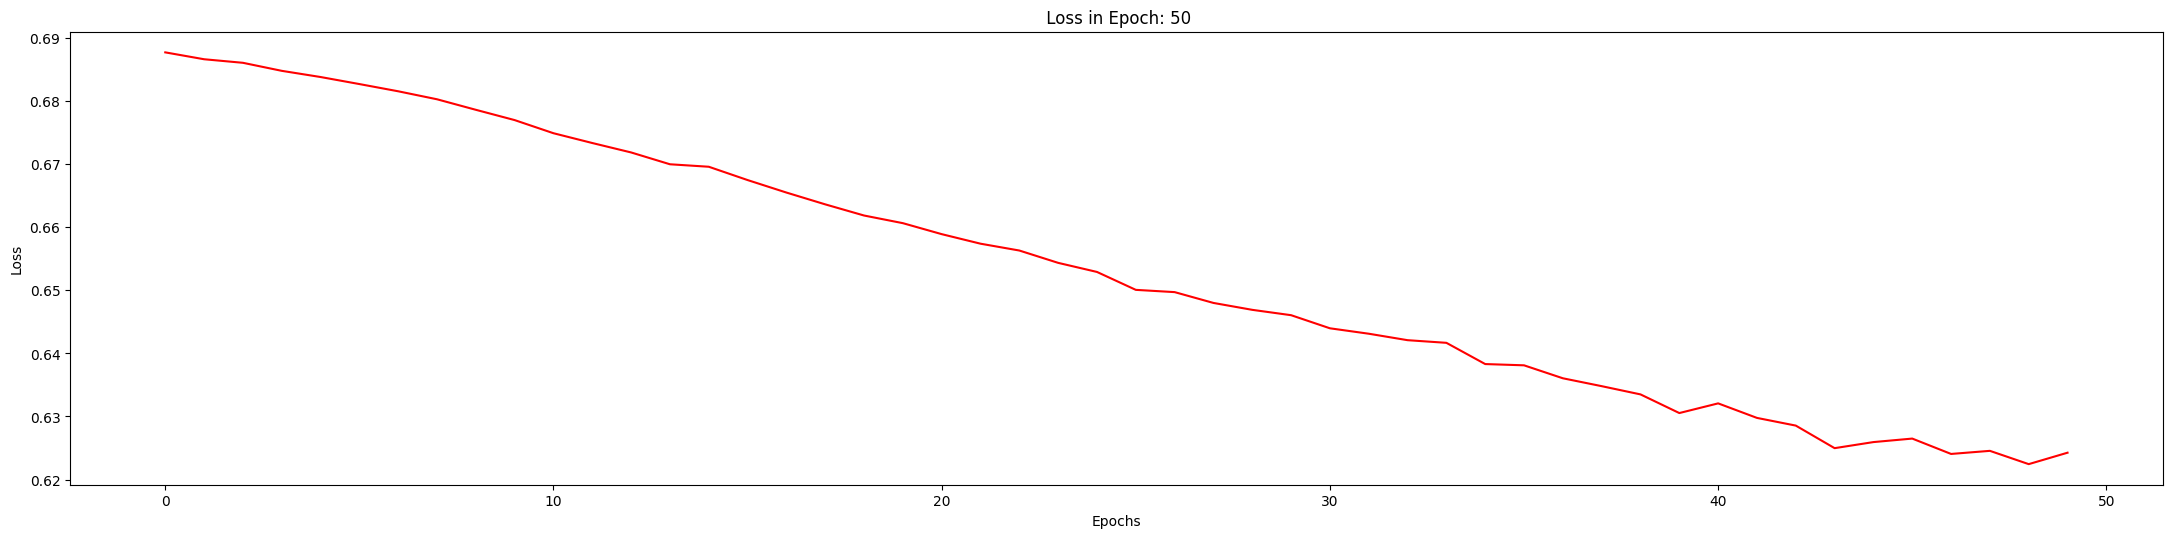

Epoch: 051, Model Loss: 0.6218
Epoch: 052, Model Loss: 0.6214
Epoch: 053, Model Loss: 0.6205
Epoch: 054, Model Loss: 0.6215
Epoch: 055, Model Loss: 0.6213
Epoch: 056, Model Loss: 0.6206
Epoch: 057, Model Loss: 0.6192
Epoch: 058, Model Loss: 0.6185
Epoch: 059, Model Loss: 0.6191
Epoch: 060, Model Loss: 0.6194
Epoch: 061, Model Loss: 0.6180
Epoch: 062, Model Loss: 0.6170
Epoch: 063, Model Loss: 0.6182
Epoch: 064, Model Loss: 0.6183
Epoch: 065, Model Loss: 0.6169
Epoch: 066, Model Loss: 0.6161
Epoch: 067, Model Loss: 0.6176
Epoch: 068, Model Loss: 0.6146
Epoch: 069, Model Loss: 0.6132
Epoch: 070, Model Loss: 0.6124
Epoch: 071, Model Loss: 0.6137
Epoch: 072, Model Loss: 0.6115
Epoch: 073, Model Loss: 0.6134
Epoch: 074, Model Loss: 0.6120
Epoch: 075, Model Loss: 0.6123
Epoch: 076, Model Loss: 0.6108
Epoch: 077, Model Loss: 0.6114
Epoch: 078, Model Loss: 0.6132
Epoch: 079, Model Loss: 0.6101
Epoch: 080, Model Loss: 0.6104
Epoch: 081, Model Loss: 0.6090
Epoch: 082, Model Loss: 0.6073
Epoch: 0

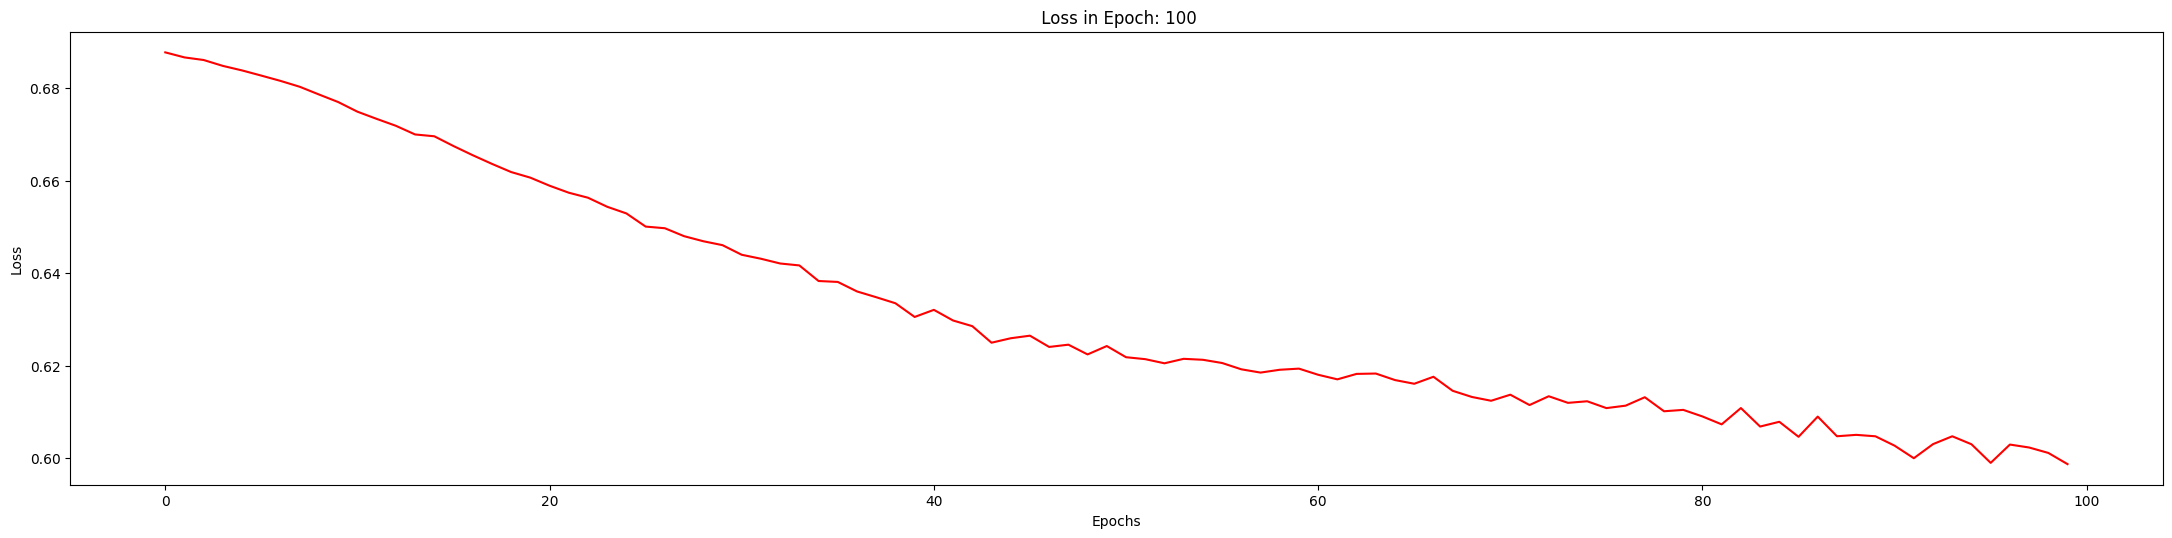

Epoch: 101, Model Loss: 0.5977
Epoch: 102, Model Loss: 0.5958
Epoch: 103, Model Loss: 0.5962
Epoch: 104, Model Loss: 0.5963
Epoch: 105, Model Loss: 0.5967
Epoch: 106, Model Loss: 0.5957
Epoch: 107, Model Loss: 0.5929
Epoch: 108, Model Loss: 0.5943
Epoch: 109, Model Loss: 0.5920
Epoch: 110, Model Loss: 0.5949
Epoch: 111, Model Loss: 0.5929
Epoch: 112, Model Loss: 0.5923
Epoch: 113, Model Loss: 0.5881
Epoch: 114, Model Loss: 0.5887
Epoch: 115, Model Loss: 0.5914
Epoch: 116, Model Loss: 0.5867
Epoch: 117, Model Loss: 0.5870
Epoch: 118, Model Loss: 0.5857
Epoch: 119, Model Loss: 0.5867
Epoch: 120, Model Loss: 0.5844
Epoch: 121, Model Loss: 0.5850
Epoch: 122, Model Loss: 0.5807
Epoch: 123, Model Loss: 0.5864
Epoch: 124, Model Loss: 0.5828
Epoch: 125, Model Loss: 0.5802
Epoch: 126, Model Loss: 0.5807
Epoch: 127, Model Loss: 0.5802
Epoch: 128, Model Loss: 0.5794
Epoch: 129, Model Loss: 0.5827
Epoch: 130, Model Loss: 0.5791
Epoch: 131, Model Loss: 0.5788
Epoch: 132, Model Loss: 0.5800
Epoch: 1

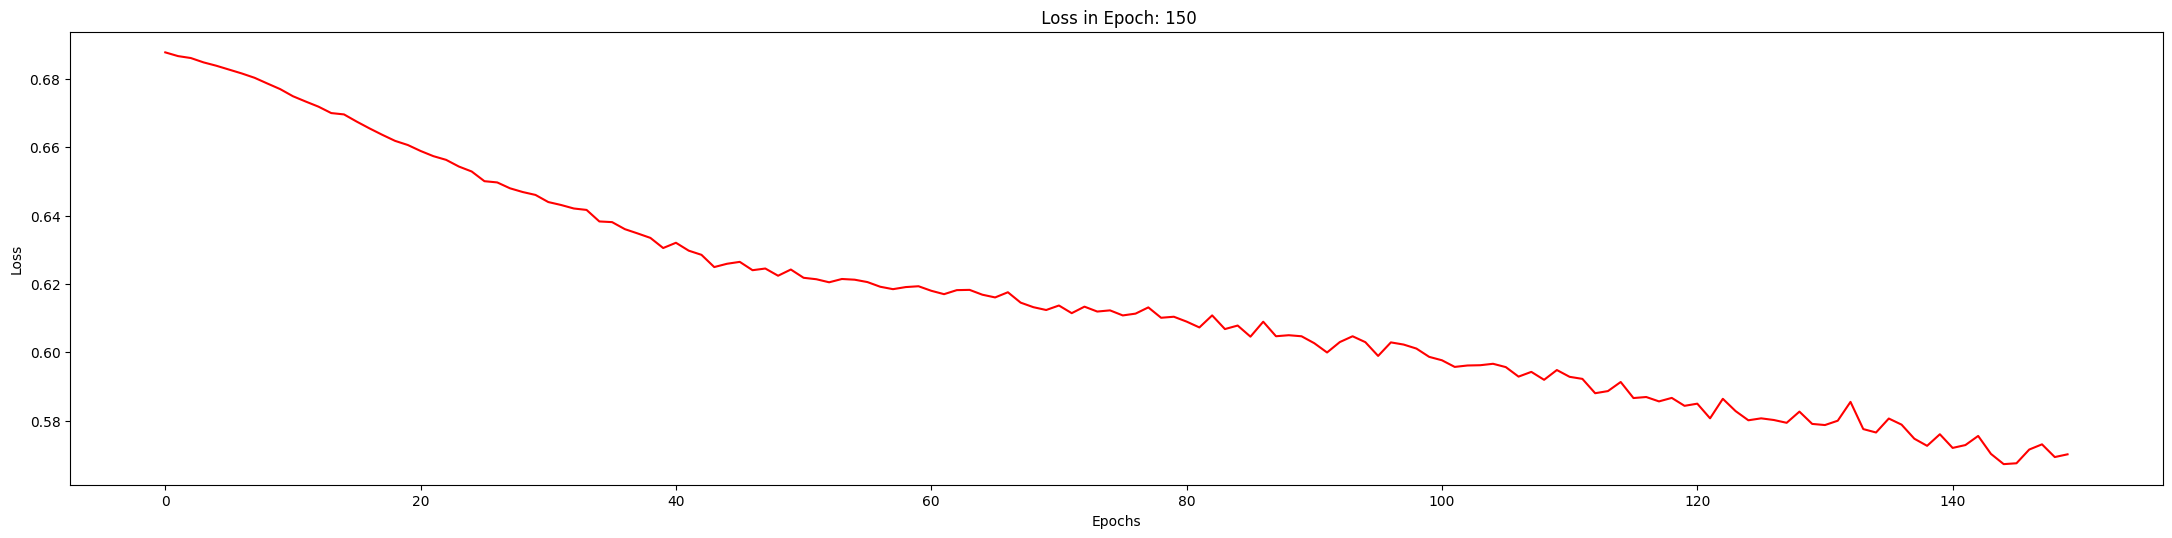

Epoch: 151, Model Loss: 0.5684
Epoch: 152, Model Loss: 0.5673
Epoch: 153, Model Loss: 0.5638
Epoch: 154, Model Loss: 0.5669
Epoch: 155, Model Loss: 0.5647
Epoch: 156, Model Loss: 0.5642
Epoch: 157, Model Loss: 0.5663
Epoch: 158, Model Loss: 0.5658
Epoch: 159, Model Loss: 0.5663
Epoch: 160, Model Loss: 0.5683
Epoch: 161, Model Loss: 0.5645
Epoch: 162, Model Loss: 0.5615
Epoch: 163, Model Loss: 0.5642
Epoch: 164, Model Loss: 0.5642
Epoch: 165, Model Loss: 0.5648
Epoch: 166, Model Loss: 0.5656
Epoch: 167, Model Loss: 0.5665
Epoch: 168, Model Loss: 0.5597
Epoch: 169, Model Loss: 0.5590
Epoch: 170, Model Loss: 0.5606
Epoch: 171, Model Loss: 0.5627
Epoch: 172, Model Loss: 0.5634
Epoch: 173, Model Loss: 0.5617
Epoch: 174, Model Loss: 0.5634
Epoch: 175, Model Loss: 0.5603
Epoch: 176, Model Loss: 0.5621
Epoch: 177, Model Loss: 0.5569
Epoch: 178, Model Loss: 0.5591
Epoch: 179, Model Loss: 0.5616
Epoch: 180, Model Loss: 0.5591
Epoch: 181, Model Loss: 0.5600
Epoch: 182, Model Loss: 0.5594
Epoch: 1

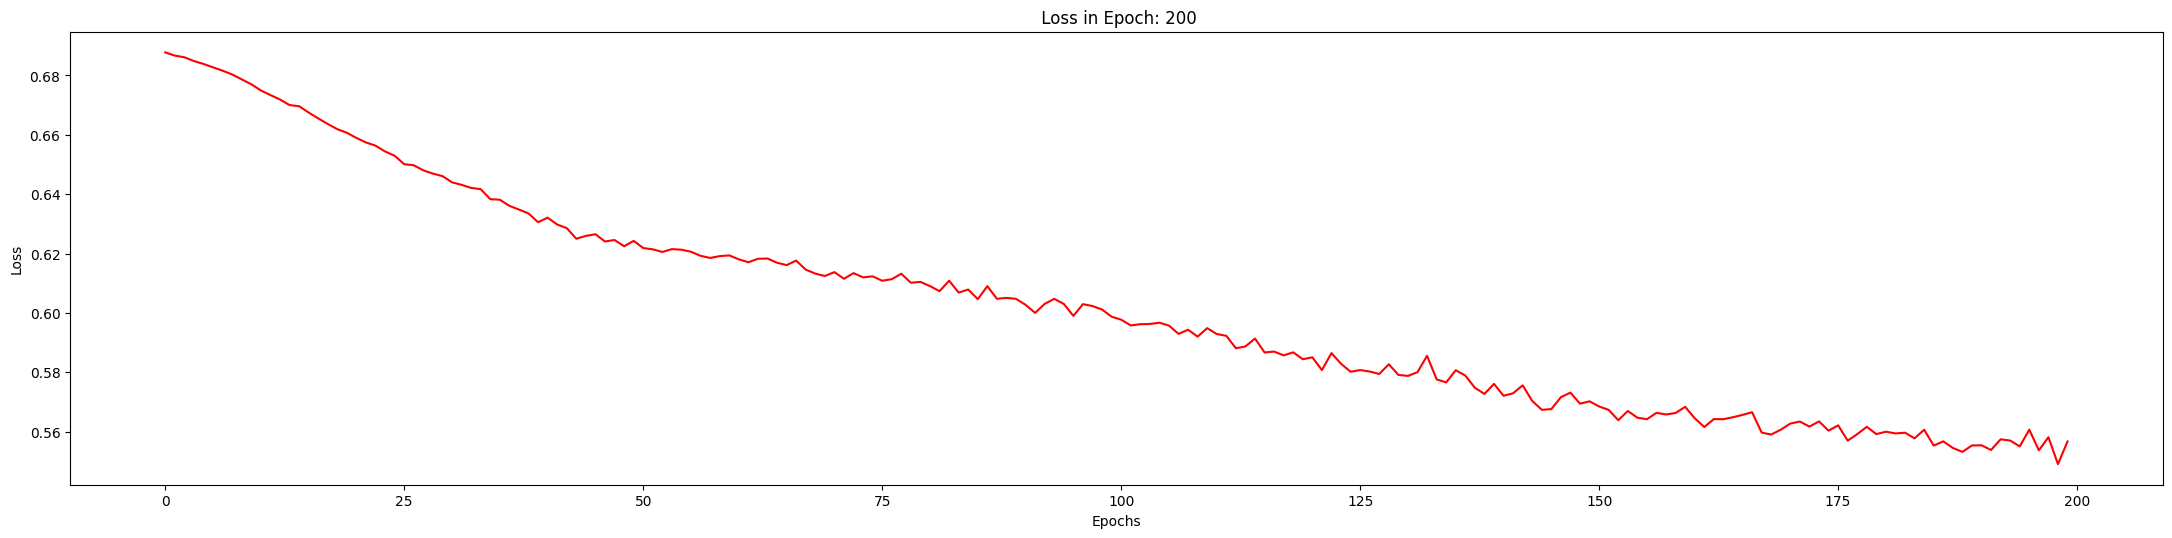

Epoch: 201, Model Loss: 0.5533
Epoch: 202, Model Loss: 0.5515
Epoch: 203, Model Loss: 0.5521
Epoch: 204, Model Loss: 0.5491
Epoch: 205, Model Loss: 0.5547
Epoch: 206, Model Loss: 0.5534
Epoch: 207, Model Loss: 0.5516
Epoch: 208, Model Loss: 0.5521
Epoch: 209, Model Loss: 0.5502
Epoch: 210, Model Loss: 0.5527
Epoch: 211, Model Loss: 0.5544
Epoch: 212, Model Loss: 0.5501
Epoch: 213, Model Loss: 0.5542
Epoch: 214, Model Loss: 0.5523
Epoch: 215, Model Loss: 0.5506
Epoch: 216, Model Loss: 0.5503
Epoch: 217, Model Loss: 0.5517
Epoch: 218, Model Loss: 0.5523
Epoch: 219, Model Loss: 0.5467
Epoch: 220, Model Loss: 0.5483
Epoch: 221, Model Loss: 0.5499
Epoch: 222, Model Loss: 0.5512
Epoch: 223, Model Loss: 0.5504
Epoch: 224, Model Loss: 0.5476
Epoch: 225, Model Loss: 0.5480
Epoch: 226, Model Loss: 0.5578
Epoch: 227, Model Loss: 0.5515
Epoch: 228, Model Loss: 0.5487
Epoch: 229, Model Loss: 0.5477
Epoch: 230, Model Loss: 0.5499
Epoch: 231, Model Loss: 0.5458
Epoch: 232, Model Loss: 0.5531
Epoch: 2

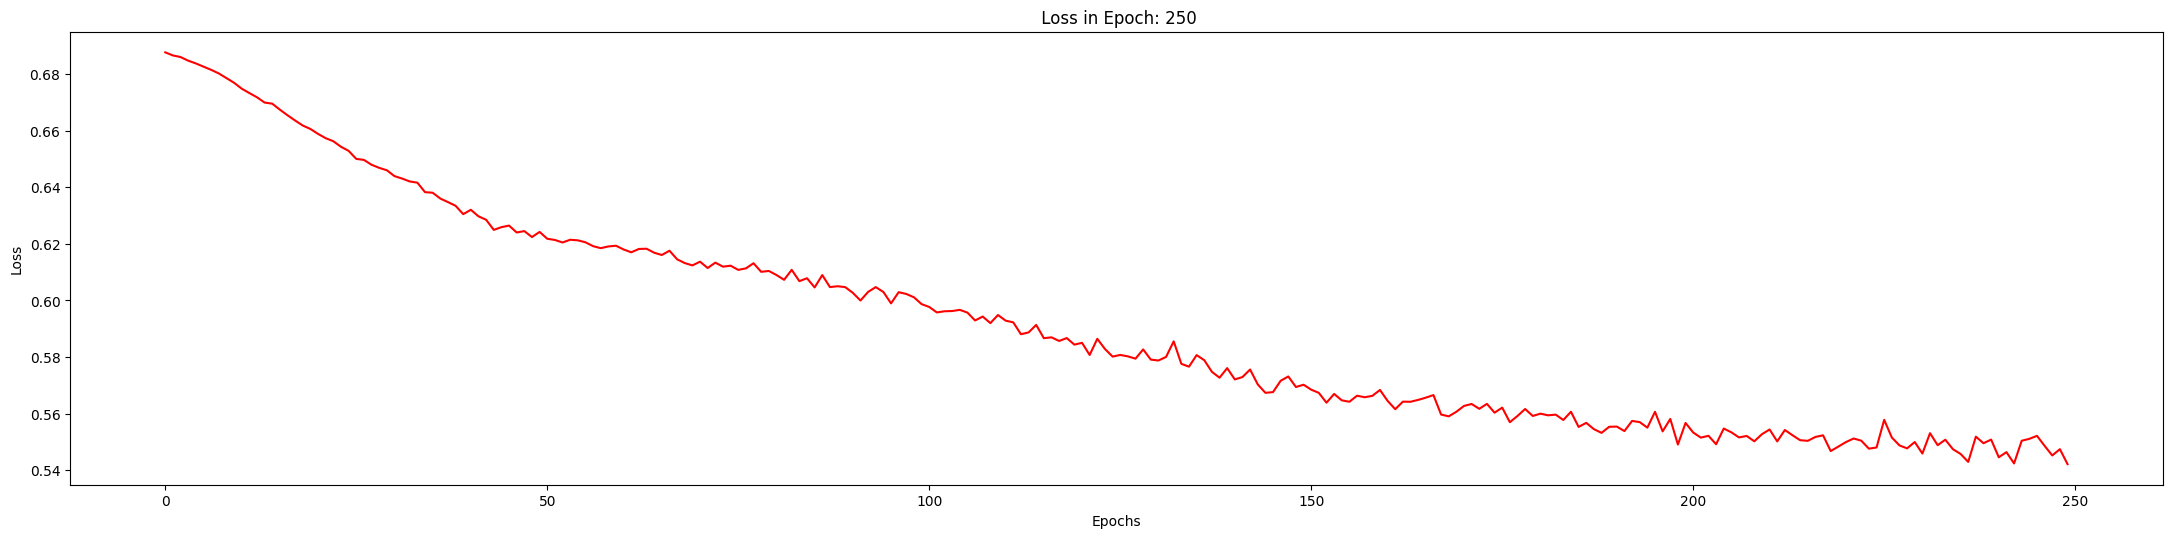

Epoch: 251, Model Loss: 0.5445
Epoch: 252, Model Loss: 0.5508
Epoch: 253, Model Loss: 0.5448
Epoch: 254, Model Loss: 0.5462
Epoch: 255, Model Loss: 0.5455
Epoch: 256, Model Loss: 0.5483
Epoch: 257, Model Loss: 0.5507
Epoch: 258, Model Loss: 0.5502
Epoch: 259, Model Loss: 0.5487
Epoch: 260, Model Loss: 0.5435
Epoch: 261, Model Loss: 0.5471
Epoch: 262, Model Loss: 0.5433
Epoch: 263, Model Loss: 0.5498
Epoch: 264, Model Loss: 0.5424
Epoch: 265, Model Loss: 0.5475
Epoch: 266, Model Loss: 0.5411
Epoch: 267, Model Loss: 0.5497
Epoch: 268, Model Loss: 0.5433
Epoch: 269, Model Loss: 0.5466
Epoch: 270, Model Loss: 0.5464
Epoch: 271, Model Loss: 0.5428
Epoch: 272, Model Loss: 0.5415
Epoch: 273, Model Loss: 0.5462
Epoch: 274, Model Loss: 0.5422
Epoch: 275, Model Loss: 0.5444
Epoch: 276, Model Loss: 0.5427
Epoch: 277, Model Loss: 0.5499
Epoch: 278, Model Loss: 0.5446
Epoch: 279, Model Loss: 0.5428
Epoch: 280, Model Loss: 0.5439
Epoch: 281, Model Loss: 0.5442
Epoch: 282, Model Loss: 0.5479
Epoch: 2

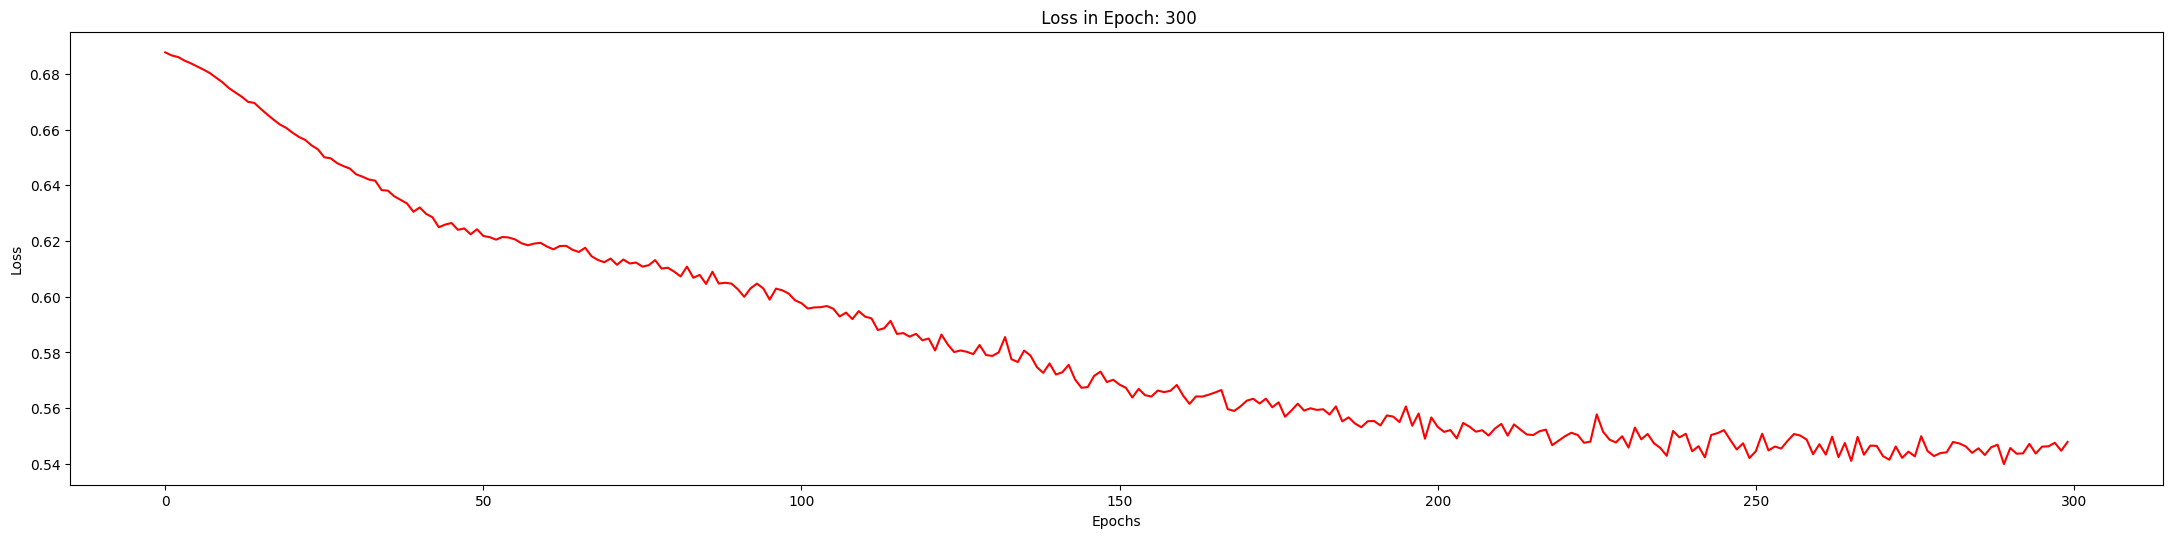

In [14]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index)

In [15]:
GNN_Model_test_predicted_labels = []
def GNN_Model_test(test_loader):
    GNN_Model.eval()
    correct = 0
    for batch_of_graphs in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        GNN_Model_test_pred = soft.argmax(dim=1)
        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs)
        #GNN_Model_test_pred = softmaxed_h2.argmax(dim=1)
        GNN_Model_test_predicted_labels.append(GNN_Model_test_pred.tolist()[0])
        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())
    return correct / len(test_loader.dataset), GNN_Model_test_predicted_labels

In [16]:
GNN_Model_test_acc, predicted_labels = GNN_Model_test(test_dataloader)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')

Test Accuracy: 0.6316


In [17]:
print(GNN_Model)
test_dataloader_example = DataLoader(test_dataset, batch_size=1, shuffle=False)
for batch in test_dataloader_example:
    #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch)
    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch)
    break
#print(softmaxed_h2)
print(soft)
print(train_dataset[0].x)

GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
tensor([[0.0223, 0.9777]], grad_fn=<SoftmaxBackward0>)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0.

In [18]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [19]:
samples_time = instance_time(test_dataset)
print(f'Test Instance based Time: {samples_time}')

Test Instance based Time: [0.006591114999991987, 0.00188298500000883, 0.0018846429999825887, 0.006941388000029747, 0.0018917259999966518, 0.006878445999973337, 0.002126431999954548, 0.0014798259999793117, 0.0014956979999851683, 0.0014250950000018747, 0.0015256300000032752, 0.0014155549999941286, 0.0019266329999823029, 0.0015742709999813087, 0.0014230770000267512, 0.0013908039999819266, 0.0014031929999873682, 0.0013713609999967957, 0.0015009800000029827, 0.0013837870000088515, 0.0013839480000115145, 0.0013658350000014252, 0.0013528039999641805, 0.0013646040000026005, 0.0013544590000265089, 0.0013508430000115368, 0.0013875210000264815, 0.001431307000018478, 0.002423873999987336, 0.0019731220000380745, 0.0019045399999981782, 0.0016043859999967935, 0.0016143980000151714, 0.0013515009999878203, 0.0014100790000384222, 0.0013309359999880144, 0.0013582070000097701, 0.0014103500000146596]


In [20]:
real_labels = []
for graph in test_dataloader:
    real_labels.append(graph.y.tolist()[0])

In [21]:
print("predicted_labels: ", predicted_labels)
print("real_labels: ", real_labels)
print("Test Accuracy: ", metrics.accuracy_score(real_labels, predicted_labels))

predicted_labels:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
real_labels:  [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
Test Accuracy:  0.631578947368421


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predicted_labels)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predicted_labels)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predicted_labels, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predicted_labels, normalize=False)
print("Auc_Roc: ", Auc_Roc, "Auc_Prc: ", Auc_Prc, "Acc: ", Acc, "Acc2: ", Acc2)

Auc_Roc:  0.5803571428571428 Auc_Prc:  0.8156833616298811 Acc:  0.6578947368421053 Acc2:  25


In [ ]:
import torch
from torch.nn.parameter import Parameter
import numpy as np
from torch import sigmoid

class HardConcrete(torch.nn.Module):

    def __init__(self, beta=1 / 3, gamma=-0.2, zeta=1.0, fix_temp=True, loc_bias=3):
        super(HardConcrete, self).__init__()

        self.temp = beta if fix_temp else Parameter(torch.zeros(1).fill_(beta))
        self.gamma = gamma
        self.zeta = zeta
        self.gamma_zeta_ratio = np.math.log(-gamma / zeta)

        self.loc_bias = loc_bias

    def forward(self, input_element, summarize_penalty=True):
        input_element = input_element + self.loc_bias

        if self.training:
            u = torch.empty_like(input_element).uniform_(1e-6, 1.0-1e-6)

            s = sigmoid((torch.log(u) - torch.log(1 - u) + input_element) / self.temp)

            penalty = sigmoid(input_element - self.temp * self.gamma_zeta_ratio)
            penalty = penalty
        else:
            s = sigmoid(input_element)
            penalty = torch.zeros_like(input_element)

        if summarize_penalty:
            penalty = penalty.mean()

        s = s * (self.zeta - self.gamma) + self.gamma

        clipped_s = self.clip(s)

        if True:
            hard_concrete = (clipped_s > 0.5).float()
            clipped_s = clipped_s + (hard_concrete - clipped_s).detach()

        return clipped_s, penalty

    def clip(self, x, min_val=0, max_val=1):
        return x.clamp(min_val, max_val)

In [ ]:
class MovingAverage:

    window_size = None
    current_value = None
    observations = None
    observation_count = None
    use_window = None

    def __init__(self, window_size=None, use_window=True):
        self.window_size = window_size

        self.current_value = 0
        self.observation_count = 0
        self.use_window = use_window

        if use_window:
            self.observations = [None] * self.window_size

    def register(self, observation):
        if self.use_window:
            current_window_idx = self.observation_count % self.window_size
            insert_value = observation / self.window_size

        if self.use_window and self.observation_count >= self.window_size:
            drop_value = self.observations[current_window_idx]
            self.current_value -= drop_value
            self.current_value += insert_value
        else:
            div_val = self.observation_count + 1
            self.current_value *= self.observation_count
            self.current_value += observation
            self.current_value /= div_val

        if self.use_window:
            self.observations[current_window_idx] = insert_value

        self.observation_count += 1

    def get_value(self):
        return self.current_value

In [ ]:
class LagrangianOptimization:

    min_alpha = None
    max_alpha = None
    original_optimizer = None
    batch_size_multiplier = None
    update_counter = 0

    def __init__(self, original_optimizer, init_alpha=0.55, min_alpha=-2, max_alpha=30, alpha_optimizer_lr=1e-2, batch_size_multiplier=None):
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha
        self.batch_size_multiplier = batch_size_multiplier
        self.update_counter = 0

        self.alpha = torch.tensor(init_alpha, requires_grad=True)
        self.optimizer_alpha = torch.optim.RMSprop([self.alpha], lr=alpha_optimizer_lr, centered=True)
        self.original_optimizer = original_optimizer

    def update(self, f, g):
        """
        L(x, lambda) = f(x) + lambda g(x)
        :param f_function:
        :param g_function:
        :return:
        """

        if self.batch_size_multiplier is not None and self.batch_size_multiplier > 1:
            if self.update_counter % self.batch_size_multiplier == 0:
                self.original_optimizer.zero_grad()
                self.optimizer_alpha.zero_grad()

            self.update_counter += 1
        else:
            self.original_optimizer.zero_grad()
            self.optimizer_alpha.zero_grad()

        loss = f + torch.nn.functional.softplus(self.alpha) * g
        loss.backward(retain_graph=True)

        if self.batch_size_multiplier is not None and self.batch_size_multiplier > 1:
            if self.update_counter % self.batch_size_multiplier == 0:
                self.original_optimizer.step()
                self.alpha.grad *= -1
                self.optimizer_alpha.step()
        else:
            self.original_optimizer.step()
            self.alpha.grad *= -1
            self.optimizer_alpha.step()

        if self.alpha.item() < -2:
            self.alpha.data = torch.full_like(self.alpha.data, -2)
        elif self.alpha.item() > 30:
            self.alpha.data = torch.full_like(self.alpha.data, 30)

In [22]:

class GraphMask:
    def __init__(self, Model_Name, classifier_load_index, explainer_save_index, Exp_Epoch, Exp_lr, explainer_hid_dim, input_dim, hid_dim, output_dim):

        ######################              MAIN
        self.beta = 1 / 3
        self.gamma = -0.2
        self.zeta = 1.0
        self.fix_temp = True
        self.loc_bias=3
        self.penalty_scaling = 1
        self.allowance = 0.03
        self.max_allowed_performance_diff = 0.05
        self.temp = self.beta if self.fix_temp else Parameter(torch.zeros(1).fill_(self.beta))
        self.gamma_zeta_ratio = np.math.log(-self.gamma / self.zeta)
        ###########
        self.GNN_Model = self.load_model(Task_name=Task_name, Explainability_name=Explainability_name, Model_Name=Model_Name, classifier_load_index=classifier_load_index, input_dim=input_dim, hid_dim=hid_dim, output_dim=output_dim)
        self.input_dim = input_dim
        self.explainer_lr = Exp_lr
        self.explainer_hid_dim = explainer_hid_dim
        self.graphmask_mlp = Sequential(Linear(self.input_dim * 2, self.explainer_hid_dim), LayerNorm(self.explainer_hid_dim), ReLU(), Linear(self.explainer_hid_dim, 1))
        self.graphmask_mlp_optimizer = torch.optim.Adam(self.graphmask_mlp.parameters(), lr=self.explainer_lr)
        self.explainer_epochs = Exp_Epoch
        #self.criterion = torch.nn.CrossEntropyLoss()
        #self.criterion = F.binary_cross_entropy_with_logits
        self.criterion = nn.L1Loss()
        self.explainer_save_index = explainer_save_index
        self.Explainability_name = 'GraphMask'
        self.Task_name = 'Graph Classification'
        self.Model_Name = "GCN_plus_GAP"

        self.baseline = torch.FloatTensor(1)
        bl_stdv = 1. / math.sqrt(1)
        self.baseline.uniform_(-bl_stdv, bl_stdv)
        self.baseline = torch.nn.Parameter(self.baseline, requires_grad=True)


        ###############.      Lagrangian Optimization
        self.min_alpha = -2
        self.max_alpha = 30
        self.update_counter = 0
        self.init_alpha = 0.55
        self.alpha_optimizer_lr=1e-2
        self.alpha = torch.tensor(self.init_alpha, requires_grad=True)
        self.optimizer_alpha = torch.optim.RMSprop([self.alpha], lr=self.alpha_optimizer_lr, centered=True)
        self.update_counter = 0





    def load_model(self, Task_name, Explainability_name, Model_Name, classifier_load_index, input_dim, hid_dim, output_dim):

        if classifier_load_index != 0:
            GNN_Model, optimizer, classifier_load_index = self.loading_config(Task_name=Task_name, Explainability_name=Explainability_name,
                                                                              Model_Name=Model_Name, classifier_load_index=classifier_load_index,
                                                                              input_dim=input_dim, hid_dim=hid_dim, output_dim=output_dim)
            return GNN_Model
        else:
            GNN_Model = Graph_Network.GCN_plus_GAP(model_name=Model_Name, model_level='graph', input_dim=input_dim, hidden_dim=hid_dim, output_dim=output_dim,
                                                   num_hid_layers=2, Bias=True, act_fun='ReLu', Weight_Initializer=1, dropout_rate=0.1)
            return GNN_Model

    def loading_config(self, Task_name, Explainability_name, Model_Name, classifier_load_index, input_dim, hid_dim, output_dim):
        GNN_Model = Graph_Network.GCN_plus_GAP(model_name=Model_Name, model_level='graph', input_dim=input_dim, hidden_dim=hid_dim,
                                               output_dim=output_dim, num_hid_layers=2, Bias=True, act_fun='ReLu',
                                               Weight_Initializer=1, dropout_rate=0.1)
        optimizer = torch.optim.Adam(params=GNN_Model.parameters(), lr=0.001, weight_decay=1e-6)
        checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Model_Name) + "_Model_classifier" + str(classifier_load_index)+".pt")
        GNN_Model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        return GNN_Model, optimizer, epoch


    def explainer_loss(self, By_Perturbation_predicted_label, predicted_label):
        loss_per_epoch = self.criterion(By_Perturbation_predicted_label, predicted_label)
        return loss_per_epoch

    def binary_concrete(self, explaier_outputs, temperature, summarize_penalty=True):
        explaier_outputs = explaier_outputs + self.loc_bias
        if self.ExTrain_or_ExTest == 'train':
            u = torch.empty_like(explaier_outputs).uniform_(1e-6, 1.0-1e-6)
            s = sigmoid((torch.log(u) - torch.log(1 - u) + explaier_outputs) / temperature)
            penalty = sigmoid(explaier_outputs - temperature * self.gamma_zeta_ratio)
        else:
            s = sigmoid(explaier_outputs)
            penalty = torch.zeros_like(explaier_outputs)

        if summarize_penalty:
            penalty = penalty.mean()

        s = s * (self.zeta - self.gamma) + self.gamma
        clipped_s = s.clamp(min=0, max=1)

        hard_concrete = (clipped_s > 0.5).float()
        clipped_s = clipped_s + (hard_concrete - clipped_s).detach()
        clipped_s = clipped_s.squeeze(dim=-1)

        return clipped_s, penalty

    def lagrangian_optimization_update(self, f, g, batch_size_multiplier):

        if batch_size_multiplier is not None and batch_size_multiplier > 1:
            if self.update_counter % batch_size_multiplier == 0:
                self.graphmask_mlp_optimizer.zero_grad()
                self.optimizer_alpha.zero_grad()

            self.update_counter += 1
        else:
            self.graphmask_mlp_optimizer.zero_grad()
            self.optimizer_alpha.zero_grad()

        loss = f + torch.nn.functional.softplus(self.alpha) * g
        loss.backward(retain_graph=True)

        if batch_size_multiplier is not None and batch_size_multiplier > 1:
            if self.update_counter % batch_size_multiplier == 0:
                self.graphmask_mlp_optimizer.step()
                self.alpha.grad *= -1
                self.optimizer_alpha.step()
        else:
            self.graphmask_mlp_optimizer.step()
            self.alpha.grad *= -1
            self.optimizer_alpha.step()

        if self.alpha.item() < -2:
            self.alpha.data = torch.full_like(self.alpha.data, -2)
        elif self.alpha.item() > 30:
            self.alpha.data = torch.full_like(self.alpha.data, 30)

    def train_step_explainer(self, merged_embeddings_list_batchs, GNN_Model, your_dataset, GNN_Model_preds_NOT_MASKED, target_class):

        #lagrangian_optimization = LagrangianOptimization(self.graphmask_mlp_optimizer, batch_size_multiplier=your_dataset.batch_size)
        self.graphmask_mlp.train()
        self.graphmask_mlp.zero_grad()
        for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
            explaier_outputs = self.graphmask_mlp(batched_merged_embeddings).view(-1)

            edge_mask, sparsity_penalty = self.binary_concrete(explaier_outputs, self.temp)
            #print("edge_mask: ", edge_mask)
            #print("penalty: ", sparsity_penalty)
            #print("baseline: ", baseline)
            importance_indices = edge_mask == 0
            edge_mask[importance_indices] = self.baseline
            #print(edge_mask.size(), len(batched_graphs.edge_index[0]))
            self.apply_masks(GNN_Model, edge_mask, batched_graphs.edge_index, apply_sigmoid=True)

            Output_of_Hidden_Layers_MASKED, pooling_layer_output_MASKED, ffn_output_MASKED, soft_MASKED = GNN_Model(batched_graphs)
            #print("batched_preds_NOT_MASKED: ", batched_preds_NOT_MASKED, "   ", "batched_preds_NOT_MASKED.argmax(dim=1): ", batched_preds_NOT_MASKED.argmax(dim=1))

            if target_class == "correct":
                batch_loss = self.explainer_loss(soft_MASKED.argmax(dim=1).to(torch.float32), batched_preds_NOT_MASKED.argmax(dim=1).to(torch.float32))
            else:
                batch_loss = self.explainer_loss(soft_MASKED.argmin(dim=1).to(torch.float32), batched_preds_NOT_MASKED.argmin(dim=1).to(torch.float32))

            g = torch.relu(batch_loss - self.allowance).mean()
            f = (sparsity_penalty * self.penalty_scaling)

            self.lagrangian_optimization_update(f=f, g=g, batch_size_multiplier=your_dataset.batch_size)

            batch_loss.requires_grad = True
            batch_loss.backward(retain_graph=True)
            self.graphmask_mlp_optimizer.step()

        return edge_mask

    def train_explainer(self, GNN_Model, your_dataset, target_class):
        edge_masks_per_epoch = []
        #self.clear_masks(GNN_Model)
        merged_embeddings_list = self.get_merged_embeddings(GNN_Model, your_dataset)
        GNN_Model_preds_NOT_MASKED = []
        for batch_of_graphs in your_dataset:
            Output_of_Hidden_Layers_NOT_MASKED, pooling_layer_output_NOT_MASKED, ffn_output_NOT_MASKED, soft_NOT_MASKED = GNN_Model(batch_of_graphs)
            GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)

        for epoch in range(self.explainer_epochs):
            print("Epoch: ", epoch)
            edge_mask = self.train_step_explainer(merged_embeddings_list, GNN_Model, your_dataset, GNN_Model_preds_NOT_MASKED, target_class)
            edge_masks_per_epoch.append(edge_mask)

            if (epoch + 1) == self.explainer_save_index:
                torch.save({'epoch': epoch+1, 'model_state_dict': self.graphmask_mlp.state_dict(), 'optimizer_state_dict': self.graphmask_mlp_optimizer.state_dict(), 'baseline_state_dict': self.baseline}, "/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.Model_Name) + "_Model_classifier_GraphMask_MLP_" + str(epoch + 1) + "_epochs_" + str(target_class) + ".pt")
                #torch.save({'epoch': epoch+1, 'baseline_state_dict': self.baseline}, "/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.Model_Name) + "_BaseLine_Model_classifier_GraphMask_MLP_" + str(epoch + 1) + "_epochs_" + str(target_class) + ".py")
        self.clear_masks(GNN_Model)

    def test_explainer(self, GNN_Model, your_dataset, graphmask_mlp):
        predicted_labels_MASKED = []
        merged_embeddings_list_batchs = self.get_merged_embeddings(GNN_Model, your_dataset)
        GNN_Model_preds_NOT_MASKED = []
        graphmask_mlp.eval()
        for batch_of_graphs in your_dataset:
            Output_of_Hidden_Layers_NOT_MASKED, pooling_layer_output_NOT_MASKED, ffn_output_NOT_MASKED, soft_NOT_MASKED = GNN_Model(batch_of_graphs)
            GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)

        for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
            explaier_outputs = graphmask_mlp(batched_merged_embeddings).view(-1)

            edge_mask, sparsity_penalty = self.binary_concrete(explaier_outputs, self.temp)

            importance_indices = edge_mask == 0
            edge_mask[importance_indices] = self.baseline

            self.apply_masks(GNN_Model, edge_mask, batched_graphs.edge_index, apply_sigmoid=True)

            Output_of_Hidden_Layers_MASKED, pooling_layer_output_MASKED, ffn_output_MASKED, soft_MASKED = GNN_Model(batched_graphs)
            #print(soft_MASKED.argmax(dim=1))
            predicted_labels_MASKED.append(torch.squeeze(soft_MASKED.argmax(dim=1)).tolist())
        self.clear_masks(GNN_Model)
        return predicted_labels_MASKED

    def apply_masks(self, model, mask, edge_index, apply_sigmoid):
        loop_mask = edge_index[0] != edge_index[1]

        for module in model.modules():
            if isinstance(module, MessagePassing):

                if (not isinstance(mask, Parameter)
                        and '_edge_mask' in module._parameters):
                    mask = Parameter(mask)

                module.explain = True
                module._edge_mask = mask
                module._loop_mask = loop_mask
                module._apply_sigmoid = apply_sigmoid
                #print(module._edge_mask)

    def clear_masks(self, model):

        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.explain = False
                module._edge_mask = None
                module._loop_mask = None
                module._apply_sigmoid = True
        return module

    def get_merged_embeddings(self, GNN_Model, your_dataset):
        new_embeddings_list = []
        merged_embeddings_list = []
        for batched_graphs in your_dataset:
            new_graph_by_masks = deepcopy(batched_graphs.detach())

            new_embeddings, GNN_Model_explain_predicted_labels = self.get_hopped_embeddings(GNN_Model, new_graph_by_masks)
            new_embeddings_list.append(new_embeddings)

            merged_embeddings = self.edge_embeddings(new_embeddings, new_graph_by_masks.edge_index)
            merged_embeddings_list.append(merged_embeddings)

        return merged_embeddings_list


    def edge_embeddings(self, embedding, edge_index):
        Zs = [embedding[edge_index[0]], embedding[edge_index[1]]]
        return torch.cat(Zs, dim=-1)

    def get_hopped_embeddings(self, GNN_Model, batch_of_graphs):
        GNN_Model.eval()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        GNN_Model_test_pred = soft.argmax(dim=1)
        return Output_of_Hidden_Layers[-1], GNN_Model_test_pred


    def load_explainer_mlp(self, Exp_Load_index, target_class):
        graphmask_mlp = Sequential(Linear(self.input_dim * 2, self.explainer_hid_dim), LayerNorm(self.explainer_hid_dim), ReLU(), Linear(self.explainer_hid_dim, 1))
        graphmask_mlp_optimizer = torch.optim.Adam(self.graphmask_mlp.parameters(), lr=self.explainer_lr)
        checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.Model_Name) + "_Model_classifier_GraphMask_MLP_" + str(Exp_Load_index)+"_epochs_" + str(target_class) + ".pt")
        graphmask_mlp.load_state_dict(checkpoint['model_state_dict'])
        graphmask_mlp_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        baseline = checkpoint['baseline_state_dict']
        print("BaseLine: ", target_class, "   ", baseline)



        #py_path2 = "/content/drive/My Drive/Explainability Methods/GraphMask on Graph Classification/Model/"
        #sys.path.insert(0,py_path2)

        #import GCN_plus_GAP_BaseLine_Model_classifier_GraphMask_MLP_100_epochs_correct as basline_file
        #x = basline_file['baseline_state_dict']
        #baseline = torch.FloatTensor(1)
        #bl_stdv = 1. / math.sqrt(1)
        #baseline.uniform_(-bl_stdv, bl_stdv)
        #baseline = torch.nn.Parameter(baseline, requires_grad=True)
        #baseline.load()

        return graphmask_mlp, graphmask_mlp_optimizer, baseline

    def __call__(self, ExTrain_or_ExTest,  Exp_Load_index, your_dataset, target_class):
        self.ExTrain_or_ExTest = ExTrain_or_ExTest
        if ExTrain_or_ExTest == "train":
            t1 = perf_counter()
            self.train_explainer(self.GNN_Model, your_dataset, target_class)
            t2 = perf_counter()
            print((t2 - t1) / len(your_dataset))
        elif ExTrain_or_ExTest == "test":
            graphmask_mlp, graphmask_mlp_optimizer, baseline = self.load_explainer_mlp(Exp_Load_index=Exp_Load_index, target_class="correct")
            predicted_labels = self.test_explainer(self.GNN_Model, your_dataset, graphmask_mlp)
            print("  correct predicted_labels: ", predicted_labels)

            graphmask_mlp, graphmask_mlp_optimizer, baseline = self.load_explainer_mlp(Exp_Load_index=Exp_Load_index, target_class="incorrect")
            predicted_labels = self.test_explainer(self.GNN_Model, your_dataset, graphmask_mlp)
            print("incorrect predicted_labels: ", predicted_labels)
        else:
            print("recheck")


target_class = 'correct'
ExTrain_or_ExTest = 'test'
if ExTrain_or_ExTest == 'train':
    your_datasets = train_dataloader
elif ExTrain_or_ExTest == 'test':
    your_datasets = test_dataloader
t1_start = perf_counter()
EXP = GraphMask(Model_Name="GCN_plus_GAP", classifier_load_index=200, explainer_save_index=50, Exp_Epoch=50, Exp_lr=0.001, explainer_hid_dim=7, input_dim=len(dataset[0].x[0]), hid_dim=7, output_dim=2)
EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=100, your_dataset=your_datasets, target_class=target_class)
t2_start = perf_counter()
attribution_time = (t2_start - t1_start)/len(test_dataset)
print("attribution_time: ", attribution_time)
#print("Before Training Explainer: ", self.GNN_Model.GConvs[0].lin.weight)
#print("After Training Explainer: ", self.GNN_Model.GConvs[0].lin.weight)
#t1_start = perf_counter()
#EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=100, your_dataset=test_dataloader, target_class="correct")
#EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=100, your_dataset=test_dataloader, target_class="incorrect")
#t2_start = perf_counter()
#print("duration: ", (t2_start - t1_start)/len(test_dataset))

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
ReLu is Selected.
BaseLine:  correct     Parameter containing:
tensor([0.5937], requires_grad=True)
  correct predicted_labels:  [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
BaseLine:  incorrect     Parameter containing:
tensor([0.5987], requires_grad=True)
incorrect predicted_labels:  [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
attribution_time:  0.037995182526316285


In [23]:
Model_Load_iNdex = 300
Explainer_Load_iNdex = 100

In [24]:
GNN_Model = Graph_Network.GCN_plus_GAP(model_name=Model_Name, model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
                                       num_hid_layers=2, Bias=True, act_fun='eLu', Weight_Initializer=1, dropout_rate=0.1)
optimizer = torch.optim.Adam(params=GNN_Model.parameters(), lr=0.001, weight_decay=1e-6)
checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Model_Name) + "_Model_classifier" + str(Model_Load_iNdex)+".pt")
GNN_Model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.


In [25]:
graphmask_exp_mlp = Sequential(Linear(7 * 2, 7), LayerNorm(7), ReLU(), Linear(7, 1))
graphmask_exp_mlp_optimizer = torch.optim.Adam(graphmask_exp_mlp.parameters(), lr=0.001)
checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Model_Name) + "_Model_classifier_GraphMask_MLP_" + str(Explainer_Load_iNdex)+"_epochs_" + str("correct") + ".pt")
graphmask_exp_mlp.load_state_dict(checkpoint['model_state_dict'])
graphmask_exp_mlp_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
baseline = checkpoint['baseline_state_dict']

In [ ]:
print(graphmask_exp_mlp[0].weight)

Parameter containing:
tensor([[ 0.0062, -0.2820, -0.0139, -0.1200,  0.2271,  0.0473, -0.0991,  0.2997,
         -0.0975,  0.0903,  0.1124,  0.2075,  0.1106,  0.1485],
        [-0.1856, -0.1483, -0.2525,  0.0359,  0.1367,  0.0301, -0.1564, -0.0097,
          0.0097,  0.1075, -0.1393,  0.0255, -0.0384,  0.2578],
        [-0.0550, -0.0402,  0.1312,  0.3601, -0.0793,  0.0694, -0.0983, -0.0408,
         -0.2428,  0.1215,  0.1471,  0.3302, -0.0772, -0.0252],
        [-0.0522,  0.0527, -0.1836,  0.0837,  0.0195,  0.0857,  0.1832, -0.0943,
          0.0152,  0.0313,  0.0430,  0.1401, -0.1327, -0.0347],
        [-0.0960, -0.1375, -0.1183,  0.2264, -0.1507,  0.0567, -0.2661, -0.1927,
          0.1931,  0.1570,  0.0847,  0.2798, -0.1745, -0.0859],
        [ 0.1011,  0.0825, -0.1634,  0.0206, -0.1855,  0.0183,  0.3843, -0.1947,
          0.2728,  0.1115, -0.0644, -0.1281, -0.0096,  0.3964],
        [-0.1278,  0.1743,  0.3965,  0.1644, -0.0161, -0.1782,  0.1562, -0.0465,
         -0.1552,  0.2034, 

In [26]:
graphmask_exp_mlp_incorrect = Sequential(Linear(7 * 2, 7), LayerNorm(7), ReLU(), Linear(7, 1))
graphmask_exp_mlp_optimizer_incorrect = torch.optim.Adam(graphmask_exp_mlp.parameters(), lr=0.001)
checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Model_Name) + "_Model_classifier_GraphMask_MLP_" + str(Explainer_Load_iNdex)+"_epochs_" + str("incorrect") + ".pt")
graphmask_exp_mlp_incorrect.load_state_dict(checkpoint['model_state_dict'])
graphmask_exp_mlp_optimizer_incorrect.load_state_dict(checkpoint['optimizer_state_dict'])
baseline_incorrect = checkpoint['baseline_state_dict']

In [ ]:
print(graphmask_exp_mlp_incorrect[0].weight)

Parameter containing:
tensor([[ 4.8123e-02, -1.6434e-01,  1.0144e-01, -5.9156e-02, -6.9448e-02,
          2.3637e-01,  9.3309e-02,  8.3096e-02,  1.4147e-01, -1.2781e-01,
          1.3068e-01, -1.6917e-01,  2.7500e-02, -1.6171e-01],
        [-1.3120e-01,  4.1206e-02, -1.5839e-01,  3.9083e-02,  8.3725e-02,
          7.3150e-02, -2.0741e-01,  1.2768e-01, -1.1865e-01, -2.2511e-01,
         -1.2265e-01, -2.3907e-01,  1.1076e-02, -2.6335e-01],
        [ 1.4158e-01, -2.6774e-01, -1.3787e-01,  2.6328e-01,  1.2367e-03,
         -3.9702e-01,  1.2883e-01,  5.7543e-02, -5.7718e-02,  3.0572e-01,
          1.0252e-01,  1.1231e-01, -4.8101e-02,  3.2265e-01],
        [-3.8459e-02, -2.0669e-01, -3.6284e-04, -1.5879e-01,  3.2483e-01,
         -3.1359e-01,  1.7407e-01, -3.7429e-03, -3.6867e-02,  2.7995e-01,
          1.6907e-01,  1.6184e-01,  9.2825e-02, -9.3323e-02],
        [-1.6974e-02,  6.0852e-02,  7.8571e-02,  1.2496e-01, -1.8991e-01,
         -1.2125e-01,  9.5920e-03, -2.4102e-02, -5.7652e-03, -2.

## **Evaluations**

In [27]:
beta = 1 / 3
gamma = -0.2
zeta = 1.0
fix_temp = True
loc_bias=3
penalty_scaling = 1
allowance = 0.03
max_allowed_performance_diff = 0.05
temp = beta if fix_temp else Parameter(torch.zeros(1).fill_(beta))
gamma_zeta_ratio = np.math.log(-gamma / zeta)
min_alpha = -2
max_alpha = 30
update_counter = 0
init_alpha = 0.55
alpha_optimizer_lr=1e-2
alpha = torch.tensor(init_alpha, requires_grad=True)
optimizer_alpha = torch.optim.RMSprop([alpha], lr=alpha_optimizer_lr, centered=True)
update_counter = 0
sm = torch.nn.Softmax(dim=0)

In [28]:
def Compute_ROC_AUC(your_model, your_dataset, masked):
    preds = []
    reals = []
    if masked == False:
        your_model.eval()
        for batched_data in your_dataset:
            #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = your_model(batched_data)
            #Grad_CAM_Test_One_Before_Last_Conv, Grad_CAM_Test_Last_Conv, Grad_CAM_Test_GAP, Grad_CAM_Test_out = your_model(batched_data)
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
            #logits = F.log_softmax(Grad_CAM_Test_out, dim=1)
            #prob = F.softmax(logits, dim=1)

            preds.append(soft.cpu().detach())
    else:

        your_model.eval()
        for batched_data, edge_mask in zip(your_dataset, masked):
            #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = your_model(batched_data)
            #Grad_CAM_Test_One_Before_Last_Conv, Grad_CAM_Test_Last_Conv, Grad_CAM_Test_GAP, Grad_CAM_Test_out = your_model(batched_data)
            your_model = apply_masks(your_model, edge_mask, batched_data.edge_index, apply_sigmoid=False)
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
            #logits = F.log_softmax(Grad_CAM_Test_out, dim=1)
            #prob = F.softmax(logits, dim=1)

            preds.append(soft.cpu().detach())
        clear_masks(your_model)



    for i, batched_graph in enumerate(your_dataset):
        reals.append(batched_graph.y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    #print(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)
    #print(preds)
    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc

def get_hopped_embeddings(GNN_Model, batch_of_graphs):
    GNN_Model.eval()
    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
    GNN_Model_test_pred = soft.argmax(dim=1)
    return Output_of_Hidden_Layers[-1], GNN_Model_test_pred

def edge_embeddings(embedding, edge_index):
    Zs = [embedding[edge_index[0]], embedding[edge_index[1]]]
    return torch.cat(Zs, dim=-1)

def get_merged_embeddings(GNN_Model, your_dataset):
    new_embeddings_list = []
    merged_embeddings_list = []
    for batched_graphs in your_dataset:
        new_graph_by_masks = deepcopy(batched_graphs.detach())

        new_embeddings, GNN_Model_explain_predicted_labels = get_hopped_embeddings(GNN_Model, new_graph_by_masks)
        new_embeddings_list.append(new_embeddings)

        merged_embeddings = edge_embeddings(new_embeddings, new_graph_by_masks.edge_index)
        merged_embeddings_list.append(merged_embeddings)

    return merged_embeddings_list

def binary_concrete(explaier_outputs, temperature, summarize_penalty=True):
    ExTrain_or_ExTest = 'test'
    explaier_outputs = explaier_outputs + loc_bias
    if ExTrain_or_ExTest == 'train':
        u = torch.empty_like(explaier_outputs).uniform_(1e-6, 1.0-1e-6)
        s = sigmoid((torch.log(u) - torch.log(1 - u) + explaier_outputs) / temperature)
        penalty = sigmoid(explaier_outputs - temperature * gamma_zeta_ratio)
    else:
        s = sigmoid(explaier_outputs)
        penalty = torch.zeros_like(explaier_outputs)

    if summarize_penalty:
        penalty = penalty.mean()

    s = s * (zeta - gamma) + gamma
    clipped_s = s.clamp(min=0, max=1)

    hard_concrete = (clipped_s > 0.5).float()
    clipped_s = clipped_s + (hard_concrete - clipped_s).detach()
    clipped_s = clipped_s.squeeze(dim=-1)

    return clipped_s, penalty

def apply_masks(model, mask, edge_index, apply_sigmoid):
    loop_mask = edge_index[0] != edge_index[1]

    for module in model.modules():
        if isinstance(module, MessagePassing):

            if (not isinstance(mask, Parameter)
                    and '_edge_mask' in module._parameters):
                mask = Parameter(mask)

            module.explain = True
            module._edge_mask = mask
            module._loop_mask = loop_mask
            module._apply_sigmoid = apply_sigmoid
            #print(module._edge_mask)
    return model

def clear_masks(model):

    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = False
            module._edge_mask = None
            module._loop_mask = None
            module._apply_sigmoid = True
    return module

def normalize_scores(Edge_Masks_original):
    graphs=[]
    for graph_masks in Edge_Masks_original:
        temp = []
        for edge_mask in graph_masks:
            #print((edge_mask - min(graph_masks)) * 100)/((max(graph_masks) - min(graph_masks)))
            temp.append((edge_mask - min(graph_masks)) * 100/(max(graph_masks) - min(graph_masks)))
        graphs.append(torch.stack(temp))
    return graphs

def standardize_scores(Edge_Masks_original):
    graphs=[]
    for graph_masks in Edge_Masks_original:
        temp = []
        for edge_mask in graph_masks:
            #print((edge_mask - min(graph_masks)) * 100)/((max(graph_masks) - min(graph_masks)))
            temp.append(edge_mask/max(graph_masks))
        graphs.append(torch.stack(temp))
    return graphs

def test_explainer(GNN_Model, your_dataset, graphmask_mlp):
    Edge_Masks_original = []
    predicted_labels_MASKED = []
    merged_embeddings_list_batchs = get_merged_embeddings(GNN_Model, your_dataset)
    GNN_Model_preds_NOT_MASKED = []
    graphmask_mlp.eval()
    for batch_of_graphs in your_dataset:
        Output_of_Hidden_Layers_NOT_MASKED, pooling_layer_output_NOT_MASKED, ffn_output_NOT_MASKED, soft_NOT_MASKED = GNN_Model(batch_of_graphs)
        GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)

    for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
        explaier_outputs = graphmask_mlp(batched_merged_embeddings).view(-1)

        edge_mask, sparsity_penalty = binary_concrete(explaier_outputs, temp)
        Edge_Masks_original.append(sm(explaier_outputs))

        importance_indices = edge_mask == 0
        edge_mask[importance_indices] = baseline

        apply_masks(GNN_Model, edge_mask, batched_graphs.edge_index, apply_sigmoid=True)

        Output_of_Hidden_Layers_MASKED, pooling_layer_output_MASKED, ffn_output_MASKED, soft_MASKED = GNN_Model(batched_graphs)
        #print(soft_MASKED.argmax(dim=1))
        predicted_labels_MASKED.append(torch.squeeze(soft_MASKED.argmax(dim=1)).tolist())
    clear_masks(GNN_Model)
    normalized_scores = normalize_scores(Edge_Masks_original)
    standardized_scores = standardize_scores(normalized_scores)
    return standardized_scores

def drop_important_nodes(your_dataset, importance_threshold):
    attribution_scores = []
    Edge_Masks_Dropped = test_explainer(GNN_Model, your_dataset, graphmask_exp_mlp)
    #print(Edge_Masks_Dropped)
    Edge_Masks_original = []
    for tensor in Edge_Masks_Dropped:
        Edge_Masks_original.append(deepcopy(tensor.detach()))
    #print("edge masks: ",len(Edge_Masks))
    for edge_mask in Edge_Masks_Dropped:
        #print("edge_mask: ", edge_mask)
        importance_indices = edge_mask > importance_threshold * (max(edge_mask) - min(edge_mask))
        edge_mask[importance_indices] = 0
        #print("edge_mask updated: ", edge_mask)
        #break
    #print("original Edge_masks: ", Edge_Masks_original[1])
    #print("dropped important Edge_masks: ", Edge_Masks_Dropped[1])

    return Edge_Masks_original, Edge_Masks_Dropped

def Fidelity_computation(your_model, your_dataset, importance_threshold):
    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset, False)
    print("auc_roc_before_droping_important_nodes: ", auc_roc_before_droping_important_nodes)
    Edge_Masks_original, Edge_Masks_Dropped = drop_important_nodes(your_dataset, importance_threshold)
    print("dropping importants done")
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset, Edge_Masks_Dropped)


    print("auc_roc_after_droping_important_nodes: ", auc_roc_after_droping_important_nodes)
    return auc_roc_before_droping_important_nodes-auc_roc_after_droping_important_nodes

def binarize_saliency_maps(correct_mask, incorrect_mask, importance_threshold):
    correct_binary_score_list = []
    incorrect_binary_score_list = []

    for edge_mask in correct_mask:
        correct_binary_score = ''
        #print(edge_mask)
        importance_indices = edge_mask > importance_threshold * (max(edge_mask) - min(edge_mask))
        #print(importance_indices)
        #edge_mask[importance_indices] = 0
        for edge in importance_indices:
            if edge:
                correct_binary_score += '1'
            else:
                correct_binary_score += '0'
        correct_binary_score_list.append(correct_binary_score)

    for edge_mask in incorrect_mask:
        #print(edge_mask)
        incorrect_binary_score = ''
        importance_indices = edge_mask > importance_threshold * (max(edge_mask) - min(edge_mask))
        #print(importance_indices)
        #edge_mask[importance_indices] = 0
        for edge in importance_indices:
            if edge:
                incorrect_binary_score += '1'
            else:
                incorrect_binary_score += '0'
        incorrect_binary_score_list.append(incorrect_binary_score)


    return correct_binary_score_list, incorrect_binary_score_list

def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

def normalize_for_contrastivity(gcam_atts):
    final = []
    for graph in gcam_atts:
        temp = []
        for score in graph:
            temp.append(score*10000000000 - int(score*10000000000))
        final.append(temp)
    return final

def compute_contrastivity(your_model, your_dataset, graphmask_exp_mlp, graphmask_exp_mlp_incorrect, importance_threshold):
    correct_masks = test_explainer(GNN_Model, your_dataset, graphmask_exp_mlp)
    incorrect_masks = test_explainer(GNN_Model, your_dataset, graphmask_exp_mlp_incorrect)
    #print("correct_masks: ", correct_masks)
    #correct_masks = normalize_for_contrastivity(correct_masks)
    #incorrect_masks = normalize_for_contrastivity(incorrect_masks)

    correct_binary_score, incorrect_binary_score = binarize_saliency_maps(correct_masks, incorrect_masks, importance_threshold)
    #print("  correct_binary_score: ", correct_binary_score)
    #print("incorrect_binary_score: ", incorrect_binary_score)
    h_dist_list = []
    for cor_bin_scores, incor_bin_scores in zip(correct_binary_score, incorrect_binary_score):
        h_distance = hamming_distance(cor_bin_scores, incor_bin_scores)/len(cor_bin_scores)
        h_dist_list.append(h_distance)
    return statistics.mean(h_dist_list)

#########################################################################################################            SPARSITY


def binarize_attributions(correct_mask, incorrect_mask, importance_threshold):
    correct_binary_score_list = []
    incorrect_binary_score_list = []

    for edge_mask in correct_mask:
        correct_binary_score = []
        importance_indices = edge_mask > importance_threshold * (max(edge_mask) - min(edge_mask))
        #print(importance_indices)
        #edge_mask[importance_indices] = 0
        for edge in importance_indices:
            if edge:
                correct_binary_score.append(1)
            else:
                correct_binary_score.append(0)
        correct_binary_score_list.append(correct_binary_score)

    for edge_mask in incorrect_mask:
        incorrect_binary_score = []
        importance_indices = edge_mask > importance_threshold * (max(edge_mask) - min(edge_mask))
        #print(importance_indices)
        #edge_mask[importance_indices] = 0
        for edge in importance_indices:
            if edge:
                incorrect_binary_score.append(1)
            else:
                incorrect_binary_score.append(0)
        incorrect_binary_score_list.append(incorrect_binary_score)


    return correct_binary_score_list, incorrect_binary_score_list


def compute_sparsity(your_model, your_dataset, graphmask_exp_mlp_correct, graphmask_exp_mlp_incorrect, importance_threshold):
    correct_masks = test_explainer(GNN_Model, your_dataset, graphmask_exp_mlp_correct)
    incorrect_masks = test_explainer(GNN_Model, your_dataset, graphmask_exp_mlp_incorrect)

    correct_binary_score, incorrect_binary_score = binarize_attributions(correct_masks, incorrect_masks, importance_threshold)
    sparsity_list = []
    for cor_binary_score, incor_binary_score in zip(correct_binary_score, incorrect_binary_score):
        sparsity = 1 - ((sum(cor_binary_score) + sum(incor_binary_score))/(2*len(incor_binary_score)))
        sparsity_list.append(sparsity)
    return statistics.mean(sparsity_list)

In [29]:
edge_mask_correct = test_explainer(GNN_Model, test_dataloader, graphmask_exp_mlp)
edge_mask_incorrect = test_explainer(GNN_Model, test_dataloader, graphmask_exp_mlp_incorrect)

In [30]:
#print(correct_masks)
class0_fid=[]
class1_fid=[]

class0_crs=[]
class1_crs=[]

class0_spr=[]
class1_spr=[]
for c_mask, inc_mask in zip(edge_mask_correct, edge_mask_incorrect):
    #print(c_mask.tolist())
    #print(inc_mask.tolist())
    class0_fid.append(c_mask)
    class1_fid.append(inc_mask)
    class0_crs.append(c_mask.tolist())
    class1_crs.append(inc_mask.tolist())
    class0_spr.append(c_mask.tolist())
    class1_spr.append(inc_mask.tolist())

In [31]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [32]:
fid_xmethod_example_2 = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=GNN_Model, test_data=test_dataset)
fid_score2 = fid_xmethod_example_2.my_fidelity(saliency_class0=class0_fid, saliency_class1=class1_fid, importance_threshold=0.5,
                                               style="Edge")
print(fid_score2)

0.13095238095238096


In [33]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [34]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, class0_crs,
                                                                     class1_crs, importance_threshold=0.5,
                                                                     contrast_coeff=1)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.628849314791608


In [35]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [36]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=GNN_Model, test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, class0_spr, class1_spr, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.5645503893926395


In [ ]:
fid_score = Fidelity_computation(GNN_Model, test_dataloader , 0.5)
print("Fidelity: ", fid_score)

auc_roc_before_droping_important_nodes:  0.6160714285714286
dropping importants done
auc_roc_after_droping_important_nodes:  0.4613095238095238
Fidelity:  0.15476190476190482


In [ ]:
contrastivity_score = compute_contrastivity(GNN_Model, test_dataloader, graphmask_exp_mlp, graphmask_exp_mlp_incorrect, 0.5)
print("contrastivity_score: ", contrastivity_score)

contrastivity_score:  0.5583959357801954


In [ ]:
sparsity_score = compute_sparsity(GNN_Model, test_dataloader, graphmask_exp_mlp, graphmask_exp_mlp_incorrect, 0.5)
print("sparsity_score: ", sparsity_score)

sparsity_score:  0.7208020321099023


In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
l = [Explainability_name, task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, GNN_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_score, contrastivity_score, sparsity_score, attribution_time, statistics.mean(GNN_Model_training_time_per_epoch), samples_time]

In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow(l)

In [ ]:
edge_mask_correct = test_explainer(GNN_Model, test_dataloader, graphmask_exp_mlp)
edge_mask_incorrect = test_explainer(GNN_Model, test_dataloader, graphmask_exp_mlp_incorrect)

In [ ]:
print(edge_mask_correct[0])
print(edge_mask_incorrect[0])

tensor([0.2863, 0.2847, 0.2863, 0.2837, 0.2890, 0.2591, 0.2778, 0.2868, 0.2859,
        0.2854, 0.2782, 0.2774, 0.2875, 0.2616, 0.2522, 0.2862, 0.2862, 0.2575,
        0.2782, 0.2869, 0.2815, 0.2859, 0.2854, 0.2771, 0.2497, 0.2787, 0.2040,
        0.2506, 0.0876, 0.0901, 1.0000, 0.1676, 0.2515, 0.0000, 0.1525, 0.1525,
        0.1514, 0.1514], grad_fn=<StackBackward0>)
tensor([0.9385, 0.9306, 0.9385, 0.9220, 0.9336, 0.9850, 0.9327, 1.0000, 0.9962,
        0.9982, 0.9432, 0.9322, 0.9351, 0.9901, 0.9888, 0.9131, 0.9131, 0.9794,
        0.9306, 0.9973, 0.7680, 0.9962, 0.9912, 0.9215, 0.9838, 0.7425, 0.8524,
        0.2433, 0.5032, 0.4993, 0.0000, 0.9360, 0.2319, 0.2125, 0.1685, 0.1685,
        0.1316, 0.1316], grad_fn=<StackBackward0>)


In [ ]:
class0_fid=[]
class1_fid=[]

class0_crs=[]
class1_crs=[]

class0_spr=[]
class1_spr=[]
for c_mask, inc_mask in zip(edge_mask_correct, edge_mask_incorrect):
    #print(c_mask.tolist())
    #print(inc_mask.tolist())
    class0_fid.append(c_mask)
    class1_fid.append(inc_mask)
    class0_crs.append(c_mask.tolist())
    class1_crs.append(inc_mask.tolist())
    class0_spr.append(c_mask.tolist())
    class1_spr.append(inc_mask.tolist())

In [ ]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [ ]:
fid_xmethod_example_2 = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=GNN_Model,
                                                                               test_data=test_dataset)
fid_score2 = fid_xmethod_example_2.my_fidelity(saliency_class0=class0_fid, saliency_class1=class1_fid, importance_threshold=0.01,
                                               style="Edge")
print(fid_score2)

0.14583333333333337


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [ ]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(model_name="GCN_plus_GAP",
                                                                                            a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, class0_crs,
                                                                     class1_crs, importance_threshold=0.5,
                                                                     contrast_coeff=1)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.5583959357801954


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [ ]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, class0_spr, class1_spr, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.7208020321099023
